In [ ]:
import torch
import torchvision
import pandas as pd
from pathlib import Path
from typing import Tuple,Dict,List
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
from tqdm import tqdm


In [ ]:
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

In [ ]:
device='cuda' if torch.cuda.is_available()  else 'cpu'

###1.Denoising

In [ ]:
from pathlib import Path
import zipfile
import requests

data_path=Path('Data/')
data_path.mkdir(parents=True,exist_ok=True)
path_to_test_train=data_path/'180DC'

with open(data_path/'180-dc-ml-sig-recruitment.zip','wb') as f:
  request=requests.get('https://github.com/mr-ssrakesh/Datasets/raw/refs/heads/main/180-dc-ml-sig-recruitment.zip')
  f.write(request.content)


if path_to_test_train.is_dir():
  print("Already downloaded")
else:
  path_to_test_train.mkdir(parents=True,exist_ok=True)
  with zipfile.ZipFile(data_path/'180-dc-ml-sig-recruitment.zip','r') as zipref:
    zipref.extractall(path_to_test_train)

In [ ]:
train_clean_path=path_to_test_train/'REC_DATASET'/'train'/'clean'
train_noisy_path=path_to_test_train/'REC_DATASET'/'train'/'noisy'

# test_clean_path=path_to_test_train/'REC_DATASET'/'test'/'clean'
test_noisy_path=path_to_test_train/'REC_DATASET'/'test'/'noisy'

In [ ]:
import os
classes=sorted([entry.name for entry in list(os.scandir(train_clean_path))])
classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
class_to_idx={cls:idx for idx,cls in enumerate(classes)}
class_to_idx

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [ ]:
clean_train_paths=list(train_clean_path.glob('*/*.png'))
noisy_train_paths=list(train_noisy_path.glob('*/*.png'))
len(clean_train_paths),len(noisy_train_paths)

(1795, 1795)

In [ ]:
from pathlib import Path
import glob

clean_dir = train_clean_path
noisy_dir = train_noisy_path

classes = [c.name for c in clean_dir.iterdir() if c.is_dir()]
print("Classes:", classes)

for cls in classes:
    clean_files = {Path(p).name for p in glob.glob(str(clean_dir/cls/"*"))}
    noisy_files = {Path(p).name for p in glob.glob(str(noisy_dir/cls/"*"))}
    diff = clean_files.symmetric_difference(noisy_files)
    print(cls, "mismatches:", len(diff))


Classes: ['sunflowers', 'dandelion', 'roses', 'daisy', 'tulips']
sunflowers mismatches: 0
dandelion mismatches: 0
roses mismatches: 0
daisy mismatches: 0
tulips mismatches: 0


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob

class PairedDenoiseDataset(Dataset):
    def __init__(self, clean_dir, noisy_dir, transform=None):
        self.clean_dir = Path(clean_dir)
        self.noisy_dir = Path(noisy_dir)
        self.transform = transform
        self.clean_paths = sorted([p for p in self.clean_dir.rglob("*.png")])

    def __len__(self):
       return len(self.clean_paths)

    def __getitem__(self, idx):
        clean_path = self.clean_paths[idx]
        cls = clean_path.parent.name
        noisy_path = self.noisy_dir/cls/clean_path.name

        clean = Image.open(clean_path).convert("RGB")
        noisy = Image.open(noisy_path).convert("RGB")

        if self.transform:
            clean = self.transform(clean)
            noisy = self.transform(noisy)

        return noisy, clean

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

clean_path = train_clean_path
noisy_path = train_noisy_path

train_dataset = PairedDenoiseDataset(clean_path, noisy_path, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
len(train_dataloader)



113

In [ ]:
clean_batch,noisy_batch=next(iter(train_dataloader))
len(clean_batch),len(noisy_batch)

(16, 16)

In [ ]:
# from torchvision.models import dncnn, DnCNN_Weights

# weights = DnCNN_Weights.DEFAULT
# model = dncnn(weights=weights).to(device)


In [ ]:
torch.__version__
torchvision.__version__

'0.23.0+cu126'

In [ ]:
!pip install deepinv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.1/724.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 37.8 MB/s eta 0:00:00


In [ ]:
import torch
from deepinv.models import DnCNN

device='cuda' if torch.cuda.is_available() else 'cpu'

model = DnCNN(pretrained="download").to(device)
model.eval()


Downloading: "https://huggingface.co/deepinv/dncnn/resolve/main/dncnn_sigma2_color.pth?download=true" to /root/.cache/torch/hub/checkpoints/dncnn_sigma2_color.pth


100%|██████████| 2.56M/2.56M [00:00<00:00, 23.5MB/s]


DnCNN(
  (in_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_list): ModuleList(
    (0-17): 18 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out_conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nl_list): ModuleList(
    (0-18): 19 x ReLU()
  )
)

In [ ]:
model

DnCNN(
  (in_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_list): ModuleList(
    (0-17): 18 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out_conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nl_list): ModuleList(
    (0-18): 19 x ReLU()
  )
)

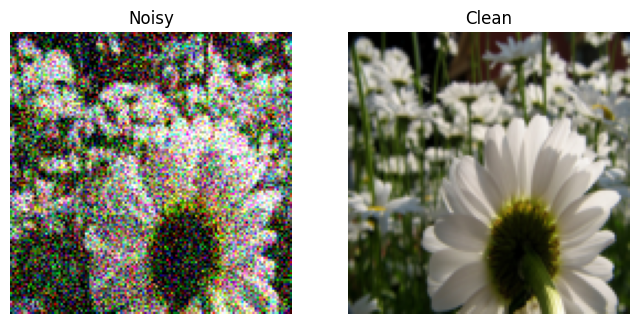

In [ ]:
import random
torch.manual_seed(42)
import matplotlib.pyplot as plt

ns,cl=train_dataset[0]

ns, cl = train_dataset[0]

ns = ns.permute(1, 2, 0).cpu().numpy()
cl = cl.permute(1, 2, 0).cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(ns)
ax[0].set_title("Noisy")
ax[0].axis("off")

ax[1].imshow(cl)
ax[1].set_title("Clean")
ax[1].axis("off")

plt.show()

In [ ]:
from torchinfo import summary
summary(model, input_size=[16, 3, 128,128])

Layer (type:depth-idx)                   Output Shape              Param #
DnCNN                                    [16, 3, 128, 128]         --
├─Conv2d: 1-1                            [16, 64, 128, 128]        1,792
├─ModuleList: 1-38                       --                        --
│    └─ReLU: 2-1                         [16, 64, 128, 128]        --
├─ModuleList: 1-37                       --                        (recursive)
│    └─Conv2d: 2-2                       [16, 64, 128, 128]        36,928
├─ModuleList: 1-38                       --                        --
│    └─ReLU: 2-3                         [16, 64, 128, 128]        --
├─ModuleList: 1-37                       --                        (recursive)
│    └─Conv2d: 2-4                       [16, 64, 128, 128]        36,928
├─ModuleList: 1-38                       --                        --
│    └─ReLU: 2-5                         [16, 64, 128, 128]        --
├─ModuleList: 1-37                       --             

In [ ]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# %%time
# num_epochs = 50

# for epoch in tqdm(range(num_epochs)):
#     model.train()
#     running_loss = 0.0

#     for noisy, clean in train_dataloader:
#         noisy, clean = noisy.to(device), clean.to(device)


#         output = model(noisy)
#         loss = loss_fn(output, clean)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")


  2%|▏         | 1/50 [00:35<28:53, 35.38s/it]

Epoch [1/50], Loss: 0.0122


  4%|▍         | 2/50 [01:11<28:36, 35.77s/it]

Epoch [2/50], Loss: 0.0057


  6%|▌         | 3/50 [01:46<27:45, 35.43s/it]

Epoch [3/50], Loss: 0.0053


  8%|▊         | 4/50 [02:20<26:47, 34.95s/it]

Epoch [4/50], Loss: 0.0050


 10%|█         | 5/50 [02:55<26:18, 35.07s/it]

Epoch [5/50], Loss: 0.0048


 12%|█▏        | 6/50 [03:29<25:22, 34.60s/it]

Epoch [6/50], Loss: 0.0047


 14%|█▍        | 7/50 [04:03<24:42, 34.47s/it]

Epoch [7/50], Loss: 0.0046


 16%|█▌        | 8/50 [04:38<24:06, 34.44s/it]

Epoch [8/50], Loss: 0.0045


 18%|█▊        | 9/50 [05:12<23:33, 34.47s/it]

Epoch [9/50], Loss: 0.0044


 20%|██        | 10/50 [05:46<22:55, 34.38s/it]

Epoch [10/50], Loss: 0.0044


 22%|██▏       | 11/50 [06:21<22:20, 34.37s/it]

Epoch [11/50], Loss: 0.0043


 24%|██▍       | 12/50 [06:55<21:49, 34.47s/it]

Epoch [12/50], Loss: 0.0043


 26%|██▌       | 13/50 [07:30<21:20, 34.60s/it]

Epoch [13/50], Loss: 0.0043


 28%|██▊       | 14/50 [08:05<20:41, 34.48s/it]

Epoch [14/50], Loss: 0.0042


 30%|███       | 15/50 [08:38<19:58, 34.24s/it]

Epoch [15/50], Loss: 0.0042


 32%|███▏      | 16/50 [09:12<19:19, 34.09s/it]

Epoch [16/50], Loss: 0.0042


 34%|███▍      | 17/50 [09:46<18:40, 33.96s/it]

Epoch [17/50], Loss: 0.0042


 36%|███▌      | 18/50 [10:19<18:03, 33.85s/it]

Epoch [18/50], Loss: 0.0041


 38%|███▊      | 19/50 [10:53<17:27, 33.79s/it]

Epoch [19/50], Loss: 0.0041


 40%|████      | 20/50 [11:27<16:52, 33.75s/it]

Epoch [20/50], Loss: 0.0041


 42%|████▏     | 21/50 [12:00<16:17, 33.72s/it]

Epoch [21/50], Loss: 0.0040


 44%|████▍     | 22/50 [12:34<15:43, 33.69s/it]

Epoch [22/50], Loss: 0.0040


 46%|████▌     | 23/50 [13:07<15:08, 33.65s/it]

Epoch [23/50], Loss: 0.0040


 48%|████▊     | 24/50 [13:41<14:34, 33.64s/it]

Epoch [24/50], Loss: 0.0040


 50%|█████     | 25/50 [14:15<14:00, 33.63s/it]

Epoch [25/50], Loss: 0.0040


 52%|█████▏    | 26/50 [14:48<13:26, 33.62s/it]

Epoch [26/50], Loss: 0.0040


 54%|█████▍    | 27/50 [15:22<12:52, 33.61s/it]

Epoch [27/50], Loss: 0.0040


 56%|█████▌    | 28/50 [15:55<12:19, 33.63s/it]

Epoch [28/50], Loss: 0.0039


 58%|█████▊    | 29/50 [16:29<11:46, 33.65s/it]

Epoch [29/50], Loss: 0.0039


 60%|██████    | 30/50 [17:03<11:12, 33.64s/it]

Epoch [30/50], Loss: 0.0039


 62%|██████▏   | 31/50 [17:36<10:38, 33.63s/it]

Epoch [31/50], Loss: 0.0039


 64%|██████▍   | 32/50 [18:10<10:05, 33.64s/it]

Epoch [32/50], Loss: 0.0039


 66%|██████▌   | 33/50 [18:44<09:32, 33.66s/it]

Epoch [33/50], Loss: 0.0039


 68%|██████▊   | 34/50 [19:17<08:58, 33.66s/it]

Epoch [34/50], Loss: 0.0039


 70%|███████   | 35/50 [19:51<08:24, 33.66s/it]

Epoch [35/50], Loss: 0.0039


 72%|███████▏  | 36/50 [20:25<07:50, 33.62s/it]

Epoch [36/50], Loss: 0.0039


 74%|███████▍  | 37/50 [20:58<07:16, 33.61s/it]

Epoch [37/50], Loss: 0.0038


 76%|███████▌  | 38/50 [21:32<06:43, 33.61s/it]

Epoch [38/50], Loss: 0.0038


 78%|███████▊  | 39/50 [22:05<06:09, 33.62s/it]

Epoch [39/50], Loss: 0.0038


 80%|████████  | 40/50 [22:39<05:36, 33.62s/it]

Epoch [40/50], Loss: 0.0038


 82%|████████▏ | 41/50 [23:13<05:02, 33.61s/it]

Epoch [41/50], Loss: 0.0038


 84%|████████▍ | 42/50 [23:46<04:28, 33.61s/it]

Epoch [42/50], Loss: 0.0038


 86%|████████▌ | 43/50 [24:20<03:55, 33.64s/it]

Epoch [43/50], Loss: 0.0038


 88%|████████▊ | 44/50 [24:54<03:21, 33.65s/it]

Epoch [44/50], Loss: 0.0038


 90%|█████████ | 45/50 [25:27<02:48, 33.63s/it]

Epoch [45/50], Loss: 0.0038


 92%|█████████▏| 46/50 [26:01<02:14, 33.64s/it]

Epoch [46/50], Loss: 0.0038


 94%|█████████▍| 47/50 [26:34<01:40, 33.62s/it]

Epoch [47/50], Loss: 0.0038


 96%|█████████▌| 48/50 [27:08<01:07, 33.63s/it]

Epoch [48/50], Loss: 0.0038


 98%|█████████▊| 49/50 [27:42<00:33, 33.64s/it]

Epoch [49/50], Loss: 0.0038


100%|██████████| 50/50 [28:15<00:00, 33.92s/it]

Epoch [50/50], Loss: 0.0038
CPU times: user 27min 24s, sys: 8.64 s, total: 27min 33s
Wall time: 28min 15s


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# torch.save(model.state_dict(), "/content/drive/MyDrive/Models/Dncnn_denoiser.pth")
model = DnCNN(pretrained="download").to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Models/Dncnn_denoiser.pth",map_location=device))
model.eval()



Mounted at /content/drive


DnCNN(
  (in_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_list): ModuleList(
    (0-17): 18 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out_conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nl_list): ModuleList(
    (0-18): 19 x ReLU()
  )
)

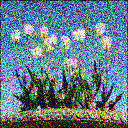

In [ ]:
test_images_path_list=list(test_noisy_path.glob('*.png'))

random_image=random.choice(test_images_path_list)

Image.open(random_image)

In [ ]:
data_path

PosixPath('Data')

In [ ]:
out_dir = Path("Train__Denoised_Images")
out_dir.mkdir(parents=True, exist_ok=True)

to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

with torch.no_grad():
    for p in sorted(train_noisy_path.rglob("*")):
        if p.suffix.lower() not in [".png", ".jpg", ".jpeg"]:
            continue

        x = to_tensor(Image.open(p).convert("RGB")).unsqueeze(0).to(device)
        y = model(x).squeeze(0).cpu().clamp(0,1)

        rel_path = p.relative_to(train_noisy_path)
        save_path = out_dir / rel_path.parent
        save_path.mkdir(parents=True, exist_ok=True)

        to_pil(y).save(save_path / p.name)


In [ ]:
train_noisy_path,test_noisy_path,out_dir

(PosixPath('Data/180DC/REC_DATASET/train/noisy'),
 PosixPath('Data/180DC/REC_DATASET/test/noisy'),
 PosixPath('Train__Denoised_Images'))

In [ ]:
out_dir = Path("Denoised_Images")
out_dir.mkdir(parents=True, exist_ok=True)

to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

with torch.no_grad():
    for p in sorted(test_noisy_path.rglob("*")):
        x = to_tensor(Image.open(p).convert("RGB")).unsqueeze(0).to(device)
        y = model(x).squeeze(0).cpu().clamp(0,1)
        to_pil(y).save(out_dir/p.name)

print("Saved denoised images to:", out_dir.resolve())

Saved denoised images to: /content/Denoised_Images


In [ ]:
denoised_images_path=Path('Denoised_Images/')

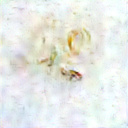

In [ ]:
import random
Image.open(random.choice(list(denoised_images_path.glob('*.png'))))

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import numpy as np
from PIL import Image
from pathlib import Path

noisy_dir = Path("Data/180DC/REC_DATASET/train/noisy")
clean_dir = Path("Data/180DC/REC_DATASET/train/clean")
denoised_dir = Path("Train__Denoised_Images")

psnr_noisy, ssim_noisy = [], []
psnr_denoised, ssim_denoised = [], []

for clean_path in sorted(clean_dir.rglob("*.png")):
    rel_path = clean_path.relative_to(clean_dir)

    noisy_path = noisy_dir / rel_path
    denoised_path = denoised_dir / rel_path

    if not noisy_path.exists() or not denoised_path.exists():
        print("Skipping (no pair):", rel_path)
        continue

    clean = np.array(Image.open(clean_path).convert("RGB"))
    noisy = np.array(Image.open(noisy_path).convert("RGB"))
    denoised = np.array(Image.open(denoised_path).convert("RGB"))

    psnr_noisy.append(psnr(clean, noisy, data_range=255))
    ssim_noisy.append(ssim(clean, noisy, channel_axis=-1, data_range=255))

    psnr_denoised.append(psnr(clean, denoised, data_range=255))
    ssim_denoised.append(ssim(clean, denoised, channel_axis=-1, data_range=255))

print("=== Noisy vs Clean ===")
print("PSNR:", np.mean(psnr_noisy))
print("SSIM:", np.mean(ssim_noisy))

print("\n=== Denoised vs Clean ===")
print("PSNR:", np.mean(psnr_denoised))
print("SSIM:", np.mean(ssim_denoised))


=== Noisy vs Clean ===
PSNR: 13.504799315539328
SSIM: 0.22614608033631983

=== Denoised vs Clean ===
PSNR: 24.48797712166811
SSIM: 0.707615617405567


###2.Classification

In [ ]:
train_dir=train_clean_path
test_dir=Path('Denoised_Images/')

train_dataset=datasets.ImageFolder(root=train_dir,transform=transform)
train_dataloader=DataLoader(dataset=train_dataset,batch_size=16,num_workers=os.cpu_count(),shuffle=True)


In [ ]:
def set_seed(seed:int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)



In [ ]:
test_images_path_list
denoised_images_path_list=list(Path('Denoised_Images/').glob('*.png'))

In [ ]:
denoised_images_path_list[:3]

[PosixPath('Denoised_Images/Image_Test_147.png'),
 PosixPath('Denoised_Images/Image_Test_527.png'),
 PosixPath('Denoised_Images/Image_Test_282.png')]

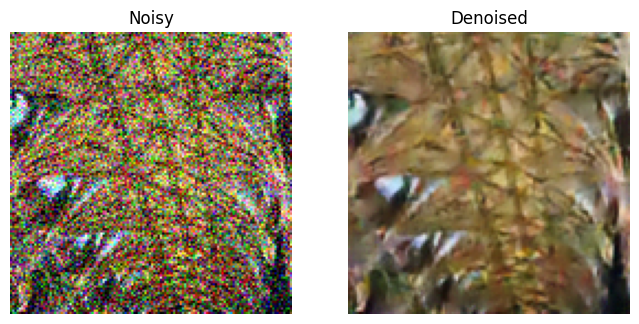

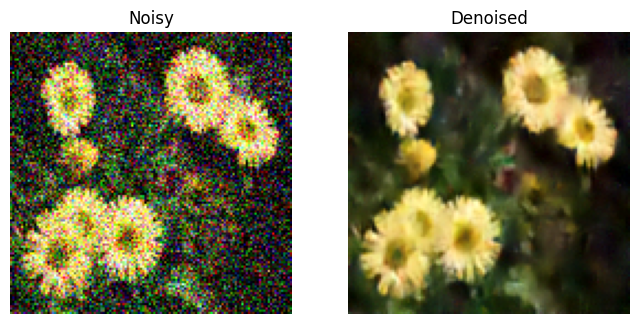

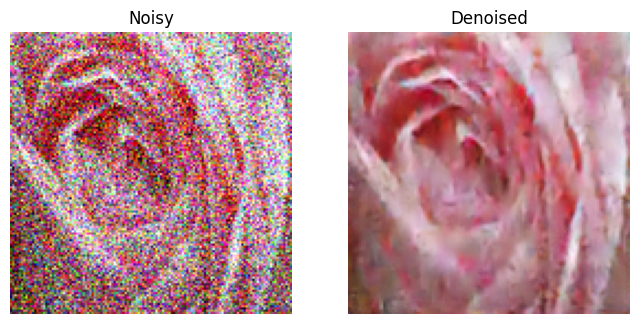

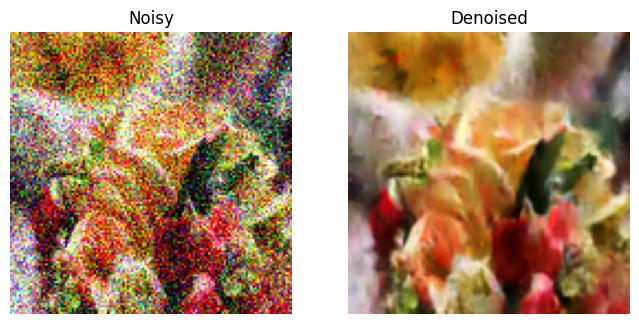

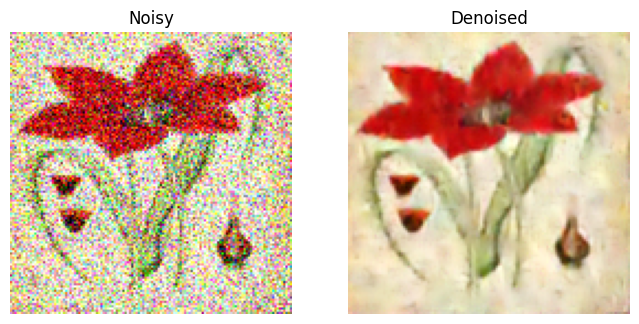

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

for i in range(5):
    noisy = test_images_path_list[i]
    denoised = denoised_images_path_list[i]

    noisy_img = Image.open(noisy)
    denoised_img = Image.open(denoised)

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(noisy_img)
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(denoised_img)
    plt.title("Denoised")
    plt.axis("off")

    plt.show()


In [ ]:
  ##Splitting train dataset to train and validation set

In [ ]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_simple_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder


dataset = ImageFolder(
    root="/content/Data/180DC/REC_DATASET/train/clean",
    transform=train_simple_transforms
)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_dataset.dataset.transform=val_transforms
train_dataset.dataset.transform=train_transforms

train_image_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_image_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)




train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_simple_dataset, val_dataset = random_split(dataset, [train_size, val_size])



train_simple_image_dataloader = DataLoader(train_simple_dataset, batch_size=32, shuffle=True)
val_image_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)





In [ ]:
len(train_image_dataloader),len(val_image_dataloader)

(45, 12)

In [ ]:

len(dataset.classes)

5

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    #Average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    print(f'Train loss : {train_loss} || Train_acc : {train_acc}')
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    print(f'Test loss : {test_loss} || Test_acc : {test_acc}')
    return test_loss, test_acc

In [ ]:
denoised_images_path_list[:3]

[PosixPath('Denoised_Images/Image_Test_147.png'),
 PosixPath('Denoised_Images/Image_Test_527.png'),
 PosixPath('Denoised_Images/Image_Test_282.png')]

In [ ]:
class_to_idx

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [ ]:
from torch import nn

In [ ]:
class TinyVGG(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_v1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=5).to(device)


In [ ]:
dataset.classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
from torch import nn
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_v1.parameters(),lr=0.001)

In [ ]:
# %%time
# from tqdm.auto import tqdm
# epochs=20

# for epoch in range(epochs):
#   model_v1.to(device)
#   print(f"Epoch no : {epoch}")
#   train_step(model=model_v1,dataloader=train_simple_image_dataloader,loss_fn=loss_fn,optimizer=optimizer)
#   test_step(model=model_v1,dataloader=val_image_dataloader,loss_fn=loss_fn)

Epoch no : 0
Train loss : 1.6182409895790948 || Train_acc : 0.2760912698412698
Test loss : 1.449241002400716 || Test_acc : 0.3195684523809524
Epoch no : 1
Train loss : 1.4656648344463772 || Train_acc : 0.32996031746031745
Test loss : 1.419451157251994 || Test_acc : 0.40029761904761907
Epoch no : 2
Train loss : 1.271317376030816 || Train_acc : 0.47073412698412703
Test loss : 1.2658546070257823 || Test_acc : 0.46688988095238093
Epoch no : 3
Train loss : 1.1729349613189697 || Train_acc : 0.514186507936508
Test loss : 1.262660985191663 || Test_acc : 0.48102678571428575
Epoch no : 4
Train loss : 1.1446478247642518 || Train_acc : 0.5265873015873016
Test loss : 1.238154912988345 || Test_acc : 0.4698660714285714
Epoch no : 5
Train loss : 1.0710284948348998 || Train_acc : 0.5490079365079364
Test loss : 1.3329513669013977 || Test_acc : 0.48102678571428575
Epoch no : 6
Train loss : 1.0631281839476692 || Train_acc : 0.5751984126984128
Test loss : 1.2140349050362904 || Test_acc : 0.4747023809523809

In [ ]:


# torch.save(model_v1.state_dict(), "/content/drive/MyDrive/Models/Tinyvgg1.pth")
model_v1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=5).to(device)
model_v1.load_state_dict(torch.load("/content/drive/MyDrive/Models/Tinyvgg1.pth",map_location=device))
model_v1.eval()


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=5, bias=True)
  )
)

In [ ]:

torch.manual_seed(42)
model_v2= TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=5).to(device)

In [ ]:
from torch import nn
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_v2.parameters(),lr=0.001)

In [ ]:
# %%time
# from tqdm.auto import tqdm
# epochs=20

# for epoch in range(epochs):
#   model_v2.to(device)
#   print(f"Epoch no : {epoch}")
#   train_step(model=model_v2,dataloader=train_image_dataloader,loss_fn=loss_fn,optimizer=optimizer)
#   test_step(model=model_v2,dataloader=val_image_dataloader,loss_fn=loss_fn)

Epoch no : 0
Train loss : 1.6665460295147365 || Train_acc : 0.23432539682539683
Test loss : 1.4717259208361309 || Test_acc : 0.38467261904761907
Epoch no : 1
Train loss : 1.358345741695828 || Train_acc : 0.41557539682539685
Test loss : 1.2683744927247365 || Test_acc : 0.4445684523809524
Epoch no : 2
Train loss : 1.2635921584235297 || Train_acc : 0.47371031746031744
Test loss : 1.221776083111763 || Test_acc : 0.47358630952380953
Epoch no : 3
Train loss : 1.2038701282607185 || Train_acc : 0.4969246031746032
Test loss : 1.2271077285210292 || Test_acc : 0.47842261904761907
Epoch no : 4
Train loss : 1.181060791015625 || Train_acc : 0.5211309523809524
Test loss : 1.1698407133420308 || Test_acc : 0.5267857142857143
Epoch no : 5
Train loss : 1.0994344724549188 || Train_acc : 0.5498015873015872
Test loss : 1.1802630970875423 || Test_acc : 0.5323660714285714
Epoch no : 6
Train loss : 1.0795065787103442 || Train_acc : 0.557936507936508
Test loss : 1.0163715581099193 || Test_acc : 0.62202380952380

In [ ]:

# torch.save(model_v2.state_dict(), "/content/drive/MyDrive/Models/Tinyvgg2.pth")
model_v2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=5).to(device)
model_v2.load_state_dict(torch.load("/content/drive/MyDrive/Models/Tinyvgg2.pth",map_location=device))
model_v2.eval()

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=5, bias=True)
  )
)

In [ ]:
class_to_idx
idx_to_class={idx:cls for idx,cls in enumerate(classes)}
idx_to_class

{0: 'sunflowers', 1: 'dandelion', 2: 'roses', 3: 'daisy', 4: 'tulips'}

tensor([1], device='cuda:0')
dandelion


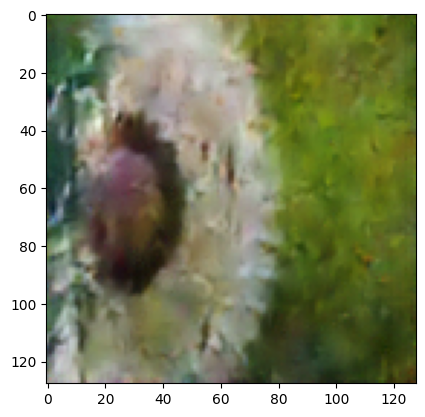

In [ ]:
import random

random_img=random.choice(denoised_images_path_list)
img=Image.open(random_img)
image_to_pass=val_transforms(img).unsqueeze(0)
pred_class_label=torch.argmax(torch.softmax(model_v2(image_to_pass.to(device)),dim=1),dim=1)
print(pred_class_label)
plt.imshow(img)
print(idx_to_class[pred_class_label.cpu().numpy()[0]])


In [ ]:
import torch
import torch.nn as nn

class FlowerClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # print("Feature shape:", x.shape)
        return self.classifier(x)



In [ ]:
model_f1 =  FlowerClassifier(num_classes=5).to(device)
dummy = torch.randn(32, 3, 128, 128).to(device)
out = model_f1(dummy.to(device))
print("Output shape:", out.shape)


Output shape: torch.Size([32, 5])


In [ ]:
from torch import nn
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_f1.parameters(),lr=0.001)

In [ ]:
# %%time
# from tqdm.auto import tqdm
# epochs=20

# for epoch in range(epochs):
#   model_f1.to(device)
#   print(f"Epoch no : {epoch}")
#   train_step(model=model_f1,dataloader=train_simple_image_dataloader,loss_fn=loss_fn,optimizer=optimizer)
#   test_step(model=model_f1,dataloader=val_image_dataloader,loss_fn=loss_fn)

In [ ]:

# torch.save(model_f1.state_dict(), "/content/drive/MyDrive/Models/Flowerclassifier1.pth")
model_f1 =  FlowerClassifier(num_classes=5).to(device)
model_f1.load_state_dict(torch.load("/content/drive/MyDrive/Models/Flowerclassifier1.pth",map_location=device))


<All keys matched successfully>

In [ ]:
model_f2 =  FlowerClassifier(num_classes=5).to(device)
dummy = torch.randn(32, 3, 128, 128).to(device)
out = model_f2(dummy.to(device))
print("Output shape:", out.shape)


from torch import nn
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_f2.parameters(),lr=0.001)

Output shape: torch.Size([32, 5])


In [ ]:
# %%time
# from tqdm.auto import tqdm
# epochs=20

# for epoch in range(epochs):
#   model_f2.to(device)
#   print(f"Epoch no : {epoch}")
#   train_step(model=model_f2,dataloader=train_image_dataloader,loss_fn=loss_fn,optimizer=optimizer)
#   test_step(model=model_f2,dataloader=val_image_dataloader,loss_fn=loss_fn)

Epoch no : 0
Train loss : 1.5831886317994859 || Train_acc : 0.2625
Test loss : 1.542865554491679 || Test_acc : 0.2775297619047619
Epoch no : 1
Train loss : 1.4613466527726915 || Train_acc : 0.33998015873015874
Test loss : 1.4361573656400044 || Test_acc : 0.44196428571428575
Epoch no : 2
Train loss : 1.380780561765035 || Train_acc : 0.39246031746031745
Test loss : 1.298963874578476 || Test_acc : 0.4058779761904762
Epoch no : 3
Train loss : 1.3039073361290825 || Train_acc : 0.4209325396825397
Test loss : 1.2336178819338481 || Test_acc : 0.40178571428571425
Epoch no : 4
Train loss : 1.2774541232320997 || Train_acc : 0.4352182539682539
Test loss : 1.255157232284546 || Test_acc : 0.43563988095238093
Epoch no : 5
Train loss : 1.2796903557247585 || Train_acc : 0.44990079365079366
Test loss : 1.2005960245927174 || Test_acc : 0.4375
Epoch no : 6
Train loss : 1.2858596351411609 || Train_acc : 0.4427579365079365
Test loss : 1.178991476694743 || Test_acc : 0.4836309523809524
Epoch no : 7
Train los

In [ ]:

# torch.save(model_f2.state_dict(), "/content/drive/MyDrive/Models/Flowerclassifier2.pth")
model_f2 =  FlowerClassifier(num_classes=5).to(device)
model_f2.load_state_dict(torch.load("/content/drive/MyDrive/Models/Flowerclassifier2.pth",map_location=device))


<All keys matched successfully>

tensor([1], device='cuda:0')
dandelion


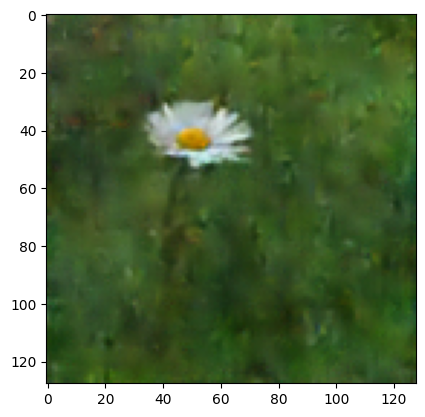

In [ ]:
import random

random_img=random.choice(denoised_images_path_list)
img=Image.open(random_img)
image_to_pass=val_transforms(img).unsqueeze(0)
pred_class_label=torch.argmax(torch.softmax(model_f1(image_to_pass.to(device)),dim=1),dim=1)
print(pred_class_label)
plt.imshow(img)
print(idx_to_class[pred_class_label.cpu().numpy()[0]])


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class FlowerNet(nn.Module):
    def __init__(self, num_classes=5):
        super(FlowerNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.gap = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1 = nn.Linear(256*4*4, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)

        x = self.gap(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model_l1=  FlowerNet(num_classes=5).to(device)
dummy = torch.randn(32, 3, 128, 128).to(device)
out = model_l1(dummy.to(device))
print("Output shape:", out.shape)

Output shape: torch.Size([32, 5])


In [ ]:
from torch import nn
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_l1.parameters(),lr=0.001)

In [ ]:
# %%time
# from tqdm.auto import tqdm
# epochs=20

# for epoch in range(epochs):
#   model_l1.to(device)
#   print(f"Epoch no : {epoch+1}")
#   train_step(model=model_l1,dataloader=train_simple_image_dataloader,loss_fn=loss_fn,optimizer=optimizer)
#   test_step(model=model_l1,dataloader=val_image_dataloader,loss_fn=loss_fn)

Epoch no : 0
Train loss : 1.823501091533237 || Train_acc : 0.29543650793650794
Test loss : 1.52488378683726 || Test_acc : 0.3976934523809524
Epoch no : 1
Train loss : 1.4498187488979764 || Train_acc : 0.3846230158730159
Test loss : 1.2733410100142162 || Test_acc : 0.47321428571428575
Epoch no : 2
Train loss : 1.3430818451775446 || Train_acc : 0.42291666666666666
Test loss : 1.267926683028539 || Test_acc : 0.44828869047619047
Epoch no : 3
Train loss : 1.246921624077691 || Train_acc : 0.4683531746031746
Test loss : 1.2969383696715038 || Test_acc : 0.45758928571428575
Epoch no : 4
Train loss : 1.2419341603914897 || Train_acc : 0.4843253968253968
Test loss : 1.1561067054669063 || Test_acc : 0.49776785714285715
Epoch no : 5
Train loss : 1.1708032343122694 || Train_acc : 0.5295634920634921
Test loss : 1.2416718651851018 || Test_acc : 0.49404761904761907
Epoch no : 6
Train loss : 1.1581601116392348 || Train_acc : 0.526686507936508
Test loss : 1.2929747998714447 || Test_acc : 0.514880952380952

In [ ]:

# torch.save(model_l1.state_dict(), "/content/drive/MyDrive/Models/Flowernet1.pth")
model_l1=  FlowerNet(num_classes=5).to(device)
model_l1.load_state_dict(torch.load("/content/drive/MyDrive/Models/Flowernet1.pth",map_location=device))

<All keys matched successfully>

In [ ]:
model_l2 =  FlowerClassifier(num_classes=5).to(device)
dummy = torch.randn(32, 3, 128, 128).to(device)
out = model_l2(dummy.to(device))
print("Output shape:", out.shape)


from torch import nn
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_l2.parameters(),lr=0.001)

Output shape: torch.Size([32, 5])


In [ ]:
# %%time
# from tqdm.auto import tqdm
# epochs=20

# for epoch in range(epochs):
#   model_l2.to(device)
#   print(f"Epoch no : {epoch+1}")
#   train_step(model=model_l2,dataloader=train_image_dataloader,loss_fn=loss_fn,optimizer=optimizer)
#   test_step(model=model_l2,dataloader=val_image_dataloader,loss_fn=loss_fn)

tensor([4], device='cuda:0')
tulips


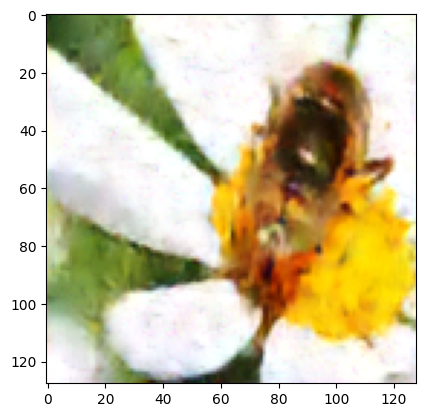

In [ ]:
import random

random_img=random.choice(denoised_images_path_list)
img=Image.open(random_img)
image_to_pass=val_transforms(img).unsqueeze(0)
pred_class_label=torch.argmax(torch.softmax(model_l2(image_to_pass.to(device)),dim=1),dim=1)
print(pred_class_label)
plt.imshow(img)
print(idx_to_class[pred_class_label.cpu().numpy()[0]])


In [ ]:
# torch.save(model_l2.state_dict(), "/content/drive/MyDrive/Models/Flowernet2.pth")
model_l2=  FlowerNet(num_classes=5).to(device)
model_l2.load_state_dict(torch.load("/content/drive/MyDrive/Models/Flowernet2.pth",map_location=device))

<All keys matched successfully>

In [1]:
##Saving test labels from all models


In [ ]:
import pandas as pd

submission_dict = {}

for path in sorted(denoised_images_path_list):
    img = Image.open(path)
    image_to_pass = val_transforms(img).unsqueeze(0).to(device)

    pred_class_label = torch.argmax(torch.softmax(model_l1(image_to_pass), dim=1), dim=1).item()

    submission_dict[path.name] = pred_class_label + 1

df = pd.DataFrame(list(submission_dict.items()), columns=["Images", "Predicted_Classes"])


df.to_csv("test_labels.csv", index=False)


In [ ]:
import pandas as pd

submission_dict = {}

for path in sorted(denoised_images_path_list):
    img = Image.open(path)
    image_to_pass = val_transforms(img).unsqueeze(0).to(device)

    pred_class_label = torch.argmax(torch.softmax(model_v2(image_to_pass), dim=1), dim=1).item()

    submission_dict[path.name] = pred_class_label + 1

df = pd.DataFrame(list(submission_dict.items()), columns=["Images", "Predicted_Classes"])


df.to_csv("test_labels2.csv", index=False)

In [ ]:
import pandas as pd

submission_dict = {}

for path in sorted(denoised_images_path_list):
    img = Image.open(path)
    image_to_pass = val_transforms(img).unsqueeze(0).to(device)

    pred_class_label = torch.argmax(torch.softmax(model_v1(image_to_pass), dim=1), dim=1).item()

    submission_dict[path.name] = pred_class_label + 1

df = pd.DataFrame(list(submission_dict.items()), columns=["Images", "Predicted_Classes"])


df.to_csv("test_labelsv1.csv", index=False)

In [ ]:
import pandas as pd

submission_dict = {}

for path in sorted(denoised_images_path_list):
    img = Image.open(path)
    image_to_pass = val_transforms(img).unsqueeze(0).to(device)

    pred_class_label = torch.argmax(torch.softmax(model_l2(image_to_pass), dim=1), dim=1).item()

    submission_dict[path.name] = pred_class_label + 1

df = pd.DataFrame(list(submission_dict.items()), columns=["Images", "Predicted_Classes"])


df.to_csv("test_labelsl2.csv", index=False)

In [ ]:
import pandas as pd

submission_dict = {}

for path in sorted(denoised_images_path_list):
    img = Image.open(path)
    image_to_pass = val_transforms(img).unsqueeze(0).to(device)

    pred_class_label = torch.argmax(torch.softmax(model_f2(image_to_pass), dim=1), dim=1).item()

    submission_dict[path.name] = pred_class_label + 1

df = pd.DataFrame(list(submission_dict.items()), columns=["Images", "Predicted_Classes"])


df.to_csv("test_labelsf2.csv", index=False)

In [ ]:
import pandas as pd

submission_dict = {}

for path in sorted(denoised_images_path_list):
    img = Image.open(path)
    image_to_pass = val_transforms(img).unsqueeze(0).to(device)

    pred_class_label = torch.argmax(torch.softmax(model_f1(image_to_pass), dim=1), dim=1).item()

    submission_dict[path.name] = pred_class_label + 1

df = pd.DataFrame(list(submission_dict.items()), columns=["Images", "Predicted_Classes"])


df.to_csv("test_labelsf1.csv", index=False)